***
# <font color=green size=10>Lista 2: Inferência estatística via simulação</font>
***

Universidade de Brasília/PPCA

Métodos Computacionais Intensivos para Mineração de Dados

Prof. Guilherme Souza Rodrigues

Aluno: Paulo Célio Soares da Silva Júnior - 22/0005605

**Importando bibliotecas.**

In [1]:
from scipy.stats import poisson
from scipy.optimize import minimize

import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import seaborn as sns

**Definindo constantes globais.**

In [2]:
# Valor da semente padrão
SEED = 42

**Montando o dataset da lista.**

In [3]:
# Carrega os arquivos csv originais
climbing_statistics = pd.read_csv("climbing_statistics.csv")
rainier_weather = pd.read_csv("Rainier_Weather.csv")

# Junta os arquivos, elimina linhas e colunas desnecessárias e renomeia colunas
dados_completos = climbing_statistics.merge(rainier_weather, left_on="Date", right_on="Date", how="left")
dados_completos = dados_completos.drop(["Success Percentage", "Battery Voltage AVG"], axis=1)
dados_completos = dados_completos.query("Attempted >= Succeeded")
dados_completos = dados_completos.rename(columns={"Date": "Data", "Succeeded": "Sucessos", "Attempted": "Tentativas",
                              "Temperature AVG": "Temperatura", "Relative Humidity AVG": "Umidade_relativa",
                              "Wind Speed Daily AVG": "Velocidade_vento", "Wind Direction AVG": "Direc_vento",
                              "Solare Radiation AVG": "Radiacao_solar"})

# Aplica as transformações nos dados
dados_completos.Temperatura = (dados_completos.Temperatura - 32) * 5 / 9
dados_completos["Cleaver"] = dados_completos.Route == "Disappointment Cleaver"
dados_completos.Data = pd.to_datetime(dados_completos.Data)

# Reordena as colunas de acordo com o layout definido para a lista
dados_completos = dados_completos.reindex(columns=["Data", "Sucessos", "Route", "Tentativas", "Temperatura", "Umidade_relativa",
                               "Velocidade_vento", "Direc_vento", "Radiacao_solar", "Cleaver"])

___

## Contextualização

"O Monte Rainier é um estratovulcão, e a montanha mais alta do estado norte-americano de Washington.(. . . ) Sua altitude é de 4392m e, em dias de tempo claro, seu pico permanentemente nevado pode ser facilmente avistado de Seattle e outras cidades da região." (*wikipédia*)

Um conjunto de dados sobre tentativas de se escalar o Monte Rainier está disponível no site *Kaggle*, e pode ser obtido pelo link [https://www.kaggle.com/codersree/mount-rainier-weather-and-climbing-data/version/3](https://www.kaggle.com/codersree/mount-rainier-weather-and-climbing-data/version/3).

Usaremos Modelos Lineares Generalizados para descrever como o número de montanhistas que alcançam o cume do monte em um dado dia (sucessos) varia em função da temperatura média do ar (em graus Celsius).

A seguir apresentamos a estrutura do banco de dados.

In [4]:
dados_completos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4067 entries, 0 to 4076
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Data              4067 non-null   datetime64[ns]
 1   Sucessos          4067 non-null   int64         
 2   Route             4067 non-null   object        
 3   Tentativas        4067 non-null   int64         
 4   Temperatura       1889 non-null   float64       
 5   Umidade_relativa  1889 non-null   float64       
 6   Velocidade_vento  1889 non-null   float64       
 7   Direc_vento       1889 non-null   float64       
 8   Radiacao_solar    1889 non-null   float64       
 9   Cleaver           4067 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 321.7+ KB


Considere o modelo $$Y_{ij} \sim Poisson(\lambda_{ij})\\ \lambda_{ij} = exp(\alpha + \beta t_{i}),$$

onde $Y_{ij}$ representa o número de montanhistas que atingiram o cume pela rota $j$ no dia $i$, $\alpha$ e $\beta$ são parâmetros desconhecidos do modelo e $t_{i}$ indica a temperatura média no dia $i$. Para uma determinada temperatura, o modelo prevê o mesmo valor para todas as rotas. Desconsidere os dados da rota *glacier only - no summit attempt*. Por fim, note que para obter o valor de $y_{ij}$ é preciso somar todos os sucessos registrados no dia $i$ para a rota $j$.

In [5]:
dados = dados_completos.query("Route != 'glacier only - no summit attempt'")

## Questão 1)

### a)

___

Conduza um teste de hipóteses por simulação para avaliar a hipótese nula de que a média do número de sucessos obtidos pela rota "Disappointment Cleaver" é igual a média das demais rotas (conjuntamente).


Separando os dois grupos (rota Disappointment Cleaver e demais rotas) e calculando suas médias e quantidades.

In [6]:
# Agrega os dados
cleaver_agg = dados.groupby(["Cleaver"]).agg({"Sucessos": ["mean", "count"]})

# Obtem médias, quantidades e diferença entre as médias
media_sucessos_nao_cleaver = cleaver_agg.iloc[0]["Sucessos"]["mean"]
media_sucessos_cleaver = cleaver_agg.iloc[1]["Sucessos"]["mean"]
quant_cleaver = cleaver_agg.iloc[1]["Sucessos"]["count"]
diferenca_medias_real = abs(media_sucessos_nao_cleaver - media_sucessos_cleaver)

# Imprime os valores
print(cleaver_agg, end="\n\n")
print(f"Valor absoluto da diferença das médias: {diferenca_medias_real:0.4f}")

         Sucessos      
             mean count
Cleaver                
False    2.082748  1281
True     3.031618  2720

Valor absoluto da diferença das médias: 0.9489


Executando as simulações e obtendo as médias e diferenças a partir 10.000 amostras aleatórias.

In [7]:
# Roda simulação com 10.000 amostras embaralhadas aleatoriamente
diferencas_medias_amostras = []
for i in range(10000):
    lista_sucessos = dados.Sucessos.sample(dados.shape[0])
    media_cleaver = np.mean(lista_sucessos[:int(quant_cleaver)])
    media_nao_cleaver = np.mean(lista_sucessos[int(quant_cleaver):])
    diferencas_medias_amostras.append(abs(media_cleaver - media_nao_cleaver))

# Imprime os valores
print(f"Maior diferença das médias encontrada: {max(diferencas_medias_amostras):0.4f}")
print(f"Diferença das médias real: {diferenca_medias_real:0.4f}")

Maior diferença das médias encontrada: 0.4176
Diferença das médias real: 0.9489


Exibindo o histograma das diferenças de médias encontradas na simulação.

<AxesSubplot:ylabel='Density'>

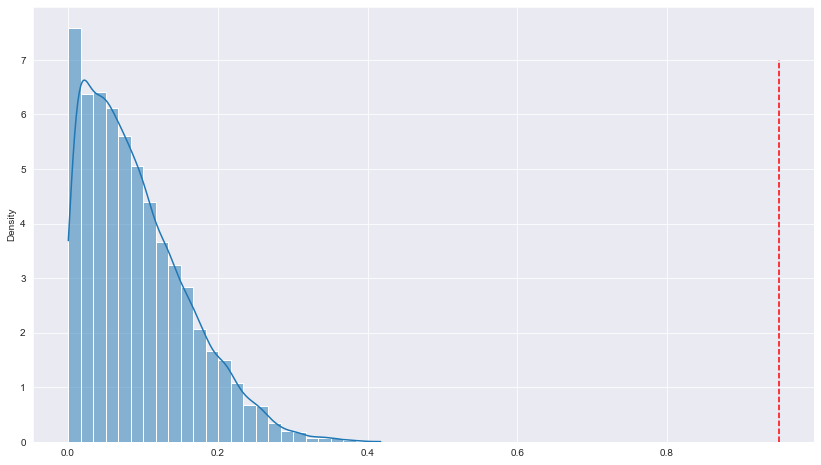

In [8]:
ax = sns.histplot(diferencas_medias_amostras, kde=True, stat="density", bins=25)
ax.figure.set_size_inches(14, 8)
ax.vlines(x=diferenca_medias_real, ymin=0, ymax=7, colors='red', linestyles='dashed')
ax

<font color='red'>**Resposta:**</font>

A partir do resultado do teste de hipótese por simulação, analisando-se as diferenças absolutas das médias encontradas, bem como o histograma gerado, a hipótese nula ($H_{0}$) de que a média do número de sucessos obtidos pela rota "Disappointment Cleaver" é igual a média das demais rotas (conjuntamente) pode ser descartada.

### b)

___

Obtenha o estimador de máxima verossimilhança de $\alpha$ e $\beta$ considerando o modelo proposto. Dica: Use a função $\textsf{optim}$ do $\textbf{\textsf{R}}$ para achar o ponto que maximiza a log-verossimilhança.

Preparando os dados para utilização na função.

In [9]:
dados_poisson = dados.groupby(["Data", "Temperatura"]).Sucessos.sum()
dados_poisson = pd.DataFrame(dados_poisson)
dados_poisson.reset_index(inplace=True)

dados_poisson.head()

,Data,Temperatura,Sucessos
0,2014-09-23,0.476296,0
1,2014-09-24,-1.276157,0
2,2014-09-25,-2.875694,8
3,2014-09-26,-2.089815,19
4,2014-09-27,0.732639,25


Definindo e minimizando a função negativa de log-verossimilhança (na prática é a mesma coisa de maximizar a função positiva).

In [18]:
def menos_log_verossimilhanca(parametros):
    alfa, beta = parametros

    lambda_previsto = np.exp(alfa + beta * dados_poisson.Temperatura)
    log_verossimilhanca = np.sum(poisson.logpmf(dados_poisson.Sucessos, lambda_previsto))

    return -1 * log_verossimilhanca

# Minimiza a função negativa de log verossimilhanca
emv = minimize(menos_log_verossimilhanca, np.array([0, 0]))

# Obtem e imprime os valores de alfa e beta
emv_alfa = emv.x[0]
emv_beta = emv.x[1]
print(f"α: {emv_alfa:0.4f}")
print(f"ß: {emv_beta:0.4f}")

α: 2.7431
ß: 0.1122


Comparando o resultado da maximização da função de log-verossimilhança com os valores de alfa e beta gerados pela biblioteca *statsmodels*.

In [17]:
modelo_poisson = smf.poisson(formula="Sucessos ~ Temperatura", data=dados_poisson)
modelo_poisson_ajustado = modelo_poisson.fit()

print(f"α: {modelo_poisson_ajustado.params[0]:0.4f}")
print(f"ß: {modelo_poisson_ajustado.params[1]:0.4f}")

Optimization terminated successfully.
         Current function value: 14.276702
         Iterations 6
α: 2.7431
ß: 0.1122


<font color='red'>**Resposta:**</font>

Considerando-se o modelo proposto, o estimador de máxima verossimilhança para $\alpha$ é 2,7431 e $\beta$ é 0,1122.

### c)

___

Estime a distribuição de probabilidade do número de sucessos previstos para um dia em que a temperatura seja de 15 graus.

<font color='red'>**Resposta:**</font>

Considerando o valor de $\lambda \cong 83$ para um dia em que a temperatura seja de $15ºC$, o gráfico abaixo ilustra a distribuição de probabilidade do número de sucessos previstos.

<AxesSubplot:ylabel='Probability'>

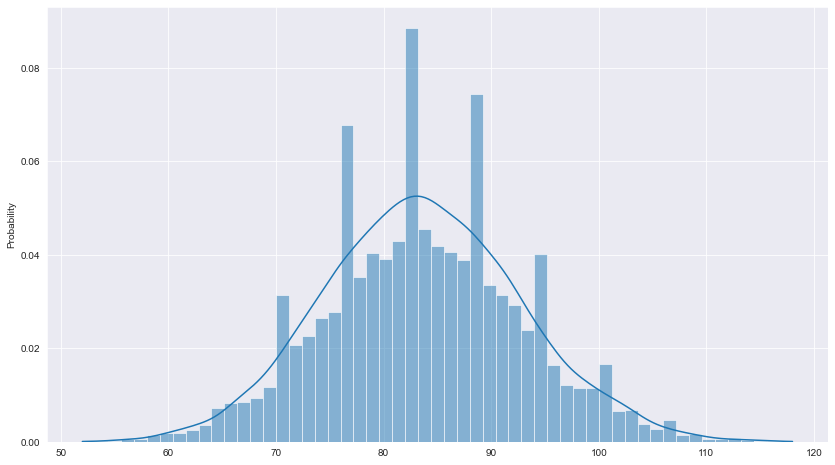

In [12]:
amostra = poisson.rvs(mu=np.exp(emv_alfa + emv_beta * 15), size=10000, random_state=SEED)
ax = sns.histplot(amostra, kde=True, stat="probability")
ax.figure.set_size_inches(14, 8)
ax

### d)

___

Construa um intervalo de confiança de $95\%$ para $exp(\beta)$ a partir do método de bootstrap paramétrico. Interprete o resultado considerando o contexto dos dados. Dica: calcule o aumento percentual da média esperada quando a temperatura aumenta em $1$ grau Celsius.

Executando o bootstrap paramétrico para o modelo proposto ()

In [54]:
lista_exp_beta = []

X = sm.add_constant(dados_poisson.Temperatura)
for _ in range(10000):
    amostra_sucessos = poisson.rvs(mu=np.exp(emv_alfa + emv_beta * dados_poisson.Temperatura), size=dados_poisson.shape[0])
    modelo_amostra = sm.GLM(amostra_sucessos, X, family=sm.families.Poisson()).fit()

    lista_exp_beta.append(np.exp(modelo_amostra.params[1]))

In [55]:
ic_exp_beta = pd.DataFrame(np.percentile(lista_exp_beta, q=[0.025, 0.975]))
ic_exp_beta = ic_exp_beta.pivot_table(0, columns=ic_exp_beta.index)
ic_exp_beta.columns = ["2.5%", "97.5%"]
ic_exp_beta

,2.5%,97.5%
0,1.107623,1.111524


In [56]:
print(f"exp(ß): {np.exp(emv_beta):0.6f}")

lambda_previsto_t = np.exp(emv_alfa + emv_beta * dados_poisson.Temperatura.iloc[0])
lambda_previsto_t_mais_1 = np.exp(emv_alfa + emv_beta * (dados_poisson.Temperatura.iloc[0] + 1))
print(f"Taxa de crescimento: {lambda_previsto_t_mais_1 / lambda_previsto_t:0.6f}")

exp(ß): 1.118696
Taxa de crescimento: 1.118696


<font color='red'>**Resposta:**</font>

### e)

___

Faça um diagnóstico do modelo via simulação. Para tanto, gere dados sintéticos usando o modelo obtido no item $\textsf{b)}$, ajuste um novo modelo sobre os dados sintéticos e calcule o Erro quadrático médio (MSE). Repita esse procedimento 10000 vezes e compare os MSEs gerados com aquele do modelo obtido em $\textsf{b)}$. Comente os resultados.

In [66]:
dados_poisson["Sucessos_previstos"] = np.exp(emv_alfa + emv_beta * dados_poisson.Temperatura)
dados_poisson["Residuos"] = dados_poisson.Sucessos - dados_poisson.Sucessos_previstos
mse = (dados_poisson.Residuos ** 2).sum() / dados_poisson.shape[0]

print(mse)

603.5770976515278


In [68]:
lista_mse = []
for _ in range(10000):
    amostra_sucessos = poisson.rvs(mu=np.exp(emv_alfa + emv_beta * dados_poisson.Temperatura), size=dados_poisson.shape[0])
    modelo_amostra = sm.GLM(amostra_sucessos, X, family=sm.families.Poisson()).fit()
    residuos = dados_poisson.Sucessos - amostra_sucessos
    mse = np.sum(residuos ** 2) / len(residuos)
    lista_mse.append(mse)

[622.5714285714286,
 637.2660098522167,
 622.0246305418719,
 644.832512315271,
 608.5862068965517,
 631.8768472906404,
 624.1527093596059,
 586.256157635468,
 633.0591133004926,
 615.960591133005,
 617.6847290640394,
 630.1428571428571,
 642.8275862068965,
 600.6305418719212,
 657.7832512315271,
 657.9852216748768,
 597.7290640394089,
 617.4187192118227,
 597.9556650246305,
 647.3743842364532,
 626.7635467980296,
 606.0886699507389,
 642.8522167487685,
 670.0541871921182,
 631.0098522167488,
 606.6108374384237,
 648.1083743842364,
 621.9852216748768,
 632.0985221674877,
 624.5911330049261,
 615.5073891625616,
 647.2857142857143,
 601.576354679803,
 612.960591133005,
 638.9408866995074,
 646.9211822660099,
 593.7389162561576,
 631.3399014778325,
 634.3940886699507,
 611.3103448275862,
 636.6847290640394,
 597.9901477832512,
 643.1773399014778,
 624.7980295566502,
 607.7980295566502,
 659.7093596059113,
 620.6009852216749,
 620.1773399014778,
 611.1231527093596,
 618.3448275862069,
 622.

[616.9852216748768,
 611.9852216748768,
 636.5123152709359,
 632.1871921182266,
 620.5714285714286]

In [69]:
ic_mse = pd.DataFrame(np.percentile(lista_mse, q=[0.025, 0.975]))
ic_mse = ic_mse.pivot_table(0, columns=ic_mse.index)
ic_mse.columns = ["2.5%", "97.5%"]
ic_mse

,2.5%,97.5%
0,556.691521,584.75294


<font color='red'>**Resposta:**</font>

## Questão bônus


Use o método de integração por Monte Carlo para estimar o volume de uma elipsoide definida por $$\frac{x^{2}}{2} + \frac{y^{2}}{3} + \frac{z^{2}}{4} = 1.$$

<font color='red'>**Resposta:**</font>